# Планирование и RL
## Алгоритмы Dyna-Q

На данном семинаре мы вначале напишем класс DynaQAgent, котрый будет представлять из себя табличного Dyna-Q агента. Проведем его сравнение с Q-learning агентом. Все варианты рассмотрим на примере среды Taxi-v2.

Для начала импортируем необходимые библиотеки

In [33]:
from collections import defaultdict
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random
import gym

%matplotlib inline

### Dyna-Q

Создадим класс DynaQAgent, который будет решать задачу обучения методом Dyna-Q, согласно приведенному ниже алгоритму.

<img src="dyna.png">

In [34]:
class DynaQAgent:
    def __init__(self, alpha, epsilon, discount, n_steps, get_legal_actions):
        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))

        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = discount
        self.n_steps = n_steps

        # создаем структуру данных для хранения информации о модели
        # self._memory_model =
        ########## Solution ############
        self.memory_model = {}
        ################################

    def get_q_value(self, state, action):
        return self._qvalues[state][action]

    def set_qvalue(self, state, action, value):
        self._qvalues[state][action] = value

    def get_value(self, state):
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        value = max(self.get_q_value(state, action) for action in possible_actions)

        return value

    def get_best_action(self, state):
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        array_qvalues = [self.get_q_value(state, action) for action in possible_actions]
        return possible_actions[array_qvalues.index(max(array_qvalues))]

    def get_action(self, state):
        # Pick Action
        possible_actions = self.get_legal_actions(state)
        action = None

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        # agent parameters:
        epsilon = self.epsilon

        if random.random() > epsilon:
            chosen_action = self.get_best_action(state)
        else:
            chosen_action = random.choice(possible_actions)

        return chosen_action


### Задание 1. Пишем функцию обновления. Здесь же запоминаем необходимую информацию для DYNA-Q.

In [85]:
def update(self, state, action, reward, next_state, use_model=True):
    # считаем обновление q
    # q =
    ########## Solution ############
    q = self.get_q_value(state, action) + self.alpha*(reward + 
                self.gamma*self.get_value(next_state) - self.get_q_value(state, action))
    ################################
    self.set_qvalue(state, action, q)
    
    # сохраняем информацию о модели
    ########## Solution ############
    if state not in self.memory_model:
        self.memory_model[state] = {}
    self.memory_model[state] = {**self.memory_model[state], **{action:(state, action, reward, next_state)}}
    ################################

    # запускаем планирование, если это был внешний вызов функции
    if use_model:
        self.planning()


DynaQAgent.update = update

### Задание 2. Следующий шаг - этап планирования (поиска). Реализуем функцию planning.

In [86]:
def planning(self):
    # делаем n_steps шагов планирования, пользуемся функцией self.update(..., use_model=False)
    ########## Solution ############
    if not self.memory_model:
        return
    for _ in range(self.n_steps):
        c_state = random.choice(list(self.memory_model))
        c_action = random.choice(list(self.memory_model[c_state].keys()))
        state, action, reward, next_state = self.memory_model[c_state][c_action]
        self.update(state, action, reward, next_state, use_model=False)
    ################################


DynaQAgent.planning = planning

### Сравнение с Q-learning

Сравним получившийся алгоритм с классическим Q-learning на примере Taxi-v2 enviroment.


Воспользуемся функцией play_and_train, которая будет полностью прогонять игру, тренировать агента на каждой паре состояние-действие и возвращать полученную награду.

In [87]:
def play_and_train(env, agent, t_max=10**4):
    """This function should 
    - run a full game, actions given by agent.getAction(s)
    - train agent using agent.update(...) whenever possible
    - return total reward"""
    total_reward = 0.0
    s = env.reset()

    for t in range(t_max):
        a = agent.get_action(s)

        next_s, r, done, _ = env.step(a)
        agent.update(s, a, r, next_s)

        s = next_s
        total_reward += r
        if done:
            break

    return total_reward

Метод run запускает сравнение алгоритмов и русует графики

In [88]:
from IPython.display import clear_output
from pandas import DataFrame

def moving_average(x, span=100): 
    return DataFrame({'x': np.asarray(x)}).x.ewm(span=span).mean().values

In [89]:
def run(alpha=0.1, epsilon=0.3, discount=0.9, planning_steps=10):
    env = gym.make("Taxi-v2")
    n_actions = env.action_space.n
    env.render()

    from qlearning import QLearningAgent

    agent_ql = QLearningAgent(alpha=alpha, epsilon=epsilon, discount=discount,
                              get_legal_actions=lambda s: range(n_actions))

    agent_dynaq = DynaQAgent(alpha=alpha, epsilon=epsilon, discount=discount, 
                             get_legal_actions=lambda s: range(n_actions), n_steps=planning_steps)

    rewards_dynaq, rewards_ql = [], []

    for i in range(1000):
        rewards_dynaq.append(play_and_train(env, agent_dynaq))
        rewards_ql.append(play_and_train(env, agent_ql))

        if i % 10 == 0:
            clear_output(True)
            print('DYNA-Q mean reward =', np.mean(rewards_dynaq[-100:]))
            print('QLEARNING mean reward =', np.mean(rewards_ql[-100:]))
            plt.plot(moving_average(rewards_dynaq), label='dyna-q')
            plt.plot(moving_average(rewards_ql), label='q-learning')
            plt.grid()
            plt.legend()
            plt.show()

### Задание  3. Проведите сравнение алгоритмов с различными гиперпараметрами. Добавьте несколько вариантов DYNA-Q с разным числом шагов планирования. Как количество шагов планирования влияет на итоговую сходимость?

DYNA-Q mean reward = 2.1
QLEARNING mean reward = -7.79


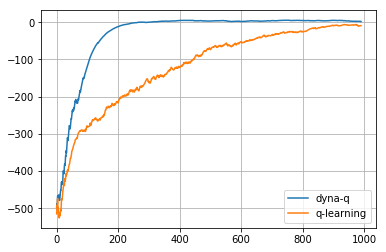

In [90]:
run(alpha=0.1, epsilon=0.1, discount=0.99, planning_steps=50)